# Zipf it up

## Zipf's law: Given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.
### This follows a basic power law (but with additional parameters):
$$ {\displaystyle{\displaystyle p(x)  \propto x^{\alpha}}} $$
### Zipf's law predicts that out of a population of $N$ elements, the normalized frequency of the element of rank $k$, $f(k;\alpha,N)$, is:

$${\displaystyle f(k;\alpha,N)={\frac {1/k^{\alpha}}{\sum \limits _{n=1}^{N}(1/n^{\alpha})}}}$$

#### A dataset can be tested to see whether Zipf's law applies by checking the "goodness of fit" of the dataset's observed rank frequency distribution to a hypothesized power law distribution, by using a Kolmogorov–Smirnov test.



#### This code does all that stuff.

In [1]:
# grepping the installation babbling basically just 
# suppresses the warnings by providing a command that will find them but won't print them.
!pip install powerlaw | grep -v 'Requirement already satisfied' 
import powerlaw
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objects as go
import plotly
from scipy.stats import hmean, norm, ks_2samp, zipf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
#data = load_dataset("c4", "en", split= "train", streaming = True)

In [3]:
# For streaming data
print('Note: Just taking the first 1000 instances.')
data_head = data.take(1000)
df = pd.DataFrame(data_head)
# If not streaming, use:
#df = pd.json_normalize(data)

Note: Just taking the first 1000 instances.


### Look at the top rows as a sanity-check

In [4]:
df.head()

,text,id
0,Mtendere Village was inspired by the vision of...,0
1,Lily James cannot fight the music. In the titl...,1
2,"""I'd love to help kickstart continued developm...",2
3,"""We view 11-11 as a top-tier, strategic partne...",3
4,Are you looking for Number the Stars (Essentia...,4


### Get more basic sanity-check information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   id      1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


### Check for missing values

In [6]:
df[df.isnull().any(axis=1)].head()
np.sum(df.isnull().any(axis=1))

0

### Count vocab size + frequencies

In [7]:
def count_vocab_frequencies(df, cutoff=0):
    """
    Based on an input pandas DataFrame with a 'text' column, 
    this function will count the occurrences of all words
    with a frequency higher than 'cutoff' and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    # Move this up as a constant in larger code.
    batch_size = 10
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    # Needed to modify the minimum token length: 
    # https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(df.text)
    document_matrix = cvec.transform(df.text)
    batches = np.linspace(0, df.shape[0], batch_size).astype(int)
    i = 0
    tf = []
    while i < len(batches) - 1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(), axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf, axis=0)], columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns = ['total']
    term_freq_df = term_freq_df[term_freq_df['total'] > cutoff]
    sorted_term_freq_df = pd.DataFrame(term_freq_df.sort_values(by='total', ascending=False)['total'])
    return sorted_term_freq_df

In [8]:
term_df = count_vocab_frequencies(df)
probability_column = term_df['total']/sum(term_df['total'])
# Grrr. This is actually the relative frequency but apparently we call it 
# 'probability' when we normalize a histogram?!
term_df['probability'] = probability_column
rank_column = term_df['total'].rank(method='dense', numeric_only=True, ascending=False)
term_df['rank'] = rank_column.astype('int64')
print("Info on the observed frequencies:")
print(term_df.info())
print("------------------------------------")
print("Vocab size (types):\t%s" % len(term_df))
print("Vocab size (tokens):\t%s" % sum(term_df['total']))
print("Observations look like this:")
print(term_df.head())
print('...')
print(term_df.tail())

Info on the observed frequencies:
<class 'pandas.core.frame.DataFrame'>
Index: 49994 entries, the to ﬁne
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total        49994 non-null  int64  
 1   probability  49994 non-null  float64
 2   rank         49994 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 1.5+ MB
None
------------------------------------
Vocab size (types):	49994
Vocab size (tokens):	1054120
Observations look like this:
     total  probability  rank
the  50142     0.047568     1
and  29384     0.027875     2
to   28256     0.026805     3
of   24251     0.023006     4
a    22043     0.020911     5
...
                   total   probability  rank
incompetently          1  9.486586e-07   579
incompetency           1  9.486586e-07   579
incompatibility        1  9.486586e-07   579
incompatibilities      1  9.486586e-07   579
ﬁne                    1  9.486586e-07   579


### Fit the observed totals to a Zipfian powerlaw.
#### Because the ranks are integers, we treat it as a discrete distribution (actually should be 'ordinal' distribution). Our reasoning is that it doesn't make sense to mandate that the distances between the ranks are equal; the values are 'ordinal' actually.
#### We fit this distribution to a power law by minimizing the Kolmogorov–Smirnov (KS) distance.
#### Our reasoning in using a KS objective rather than Maximun Likelihood Estimation (MLE) is that a fundamental assumption of MLE is that individual data points are independent, but that oughtn't be so with the use of words in language (we think)...

In [9]:
import math
# Uses the powerlaw package to fit the observed frequencies to a zipfian distribution

observed_counts = term_df['total'].values
# Turn these into an empirical probability distribution by normalizing by the total sum.
# Note -- doesn't seem to matter actually; can remove.
sum_total = float(sum(observed_counts))
observed_probabilities = observed_counts/sum_total
#observed_log_probabilities = np.log(observed_counts) - np.log(norm)
# 'fit_method' is MLE by default; doesn't seem to change the results in my initial pokings.
# Also tried discrete_approximation="xmax"
# Note another method for determining alpha 
# might be defined by (Newman, 2005 for details): alpha = 1 + n * sum(ln( xi / xmin )) ^ -1
fit = powerlaw.Fit(observed_counts, fit_method="KS", discrete=True)
# bins_edges = The edges of the bins of the probability density function.
# The portion of the data that is within the bin. Length 1 less than bin_edges, as it corresponds to the spaces between them.
# Returns the probability density function (normalized histogram) of the data.
pdf_bin_edges, observed_pdf = fit.pdf(original_data=True, linear_bins=True)
observed_pdf = np.flip(observed_pdf)
pdf_bin_edges = np.flip(pdf_bin_edges)
# This seems to basically be the 'Distribution' class described here: https://pythonhosted.org/powerlaw/#powerlaw.Fit.pdf
theoretical_distribution = fit.power_law
# The likelihoods of the observed data from the theoretical distribution.
predicted_likelihoods = theoretical_distribution.likelihoods
# The logarithm of the likelihoods of the observed data from the theoretical distribution.
predicted_log_likelihoods = theoretical_distribution.loglikelihoods
# The probability density function (normalized histogram) of the theoretical distribution
predicted_pdf = theoretical_distribution.pdf()
predicted_pdf = np.flip(predicted_pdf)
alpha = theoretical_distribution.alpha
xmin = theoretical_distribution.xmin
distance = theoretical_distribution.KS()

# We know the optimal xmin, but now let's set the prediction xmin to a lower value
# so we can graph out more beyond the cutoff.
# Note: Bring this up as a parameter that can be set.
# fit.xmin = .001

print("------------------------------------")
print("Optimal Alpha:\t\t%.4f" % alpha)
print("Optimal Frequency cut-off:\t%s" % xmin)
print("Distance:\t\t%.4f" % distance)
# Significance testing
# Note: We may want to use bootstrapping (instead of the standard KS test p-value tables) to determine statistical significance
# See: https://stats.stackexchange.com/questions/264431/how-to-determine-if-zipfs-law-can-be-applied Answer #4
print("Checking the goodness of fit of our observed distribution")
print(" to the hypothesized power law distribution")
print(" using a Kolmogorov–Smirnov (KS) test.")
ks_test = ks_2samp(observed_pdf, predicted_pdf)
# print("KS test:", end='\t\t')
print(ks_test)
print("\nThe KS test p-value is: %.4f" % ks_test.pvalue)
if ks_test.pvalue < .01:
    print("\nYour data fits a powerlaw with a minimum KS distance of %.4f" % distance)
    print("\nWoohoo!")
else:
    print("\nYour data does not fits a powerlaw. =\(")
    print("\nDO BETTER.")

Calculating best minimal value for power law fit
------------------------------------
Optimal Alpha:		1.6677
Optimal Frequency cut-off:	2.0
Distance:		0.0174
Checking the goodness of fit of our observed distribution
 to the hypothesized power law distribution
 using a Kolmogorov–Smirnov (KS) test.
KstestResult(statistic=0.9884525637701681, pvalue=0.0)

The KS test p-value is: 0.0000

Your data fits a powerlaw with a minimum KS distance of 0.0174

Woohoo!


### Use the given alpha to calulate the zipf pmf and plot.

##### We're using a cutoff here to save compute time and make the histogram readable.

In [68]:
cutoff = 50
summed_total = sum(list(term_df['total'])[:cutoff])
# Ignoring rank 0
zipf_pmf = [zipf.pmf(p, alpha) * summed_total for p in range(1, cutoff + 1)][1:]
zipf_col = pd.DataFrame(zipf_pmf, columns = ['zipf_pmf'])
term_df['zipf_pmf'] = zipf_pmf + [np.NaN] * (len(term_df) - len(zipf_pmf))
print(term_df)
# If we're using a cutoff, pad the column so it can still be added to the larger dataframe

                   total   probability  rank      zipf_pmf
the                50142  4.756764e-02     1  58023.711250
and                29384  2.787538e-02     2  29507.872760
to                 28256  2.680530e-02     3  18263.223048
of                 24251  2.300592e-02     4  12588.108564
a                  22043  2.091128e-02     5   9287.735139
...                  ...           ...   ...           ...
incompetently          1  9.486586e-07   579           NaN
incompetency           1  9.486586e-07   579           NaN
incompatibility        1  9.486586e-07   579           NaN
incompatibilities      1  9.486586e-07   579           NaN
ﬁne                    1  9.486586e-07   579           NaN

[49994 rows x 4 columns]


In [79]:
termplot=term_df[:cutoff]
termplot['word'] = termplot.index
wordlist=[]
for w in termplot.groupby('rank'):
    wordlist.append((w[1]['word'][0]))

/home/sasha/miniconda3/envs/datametrics/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



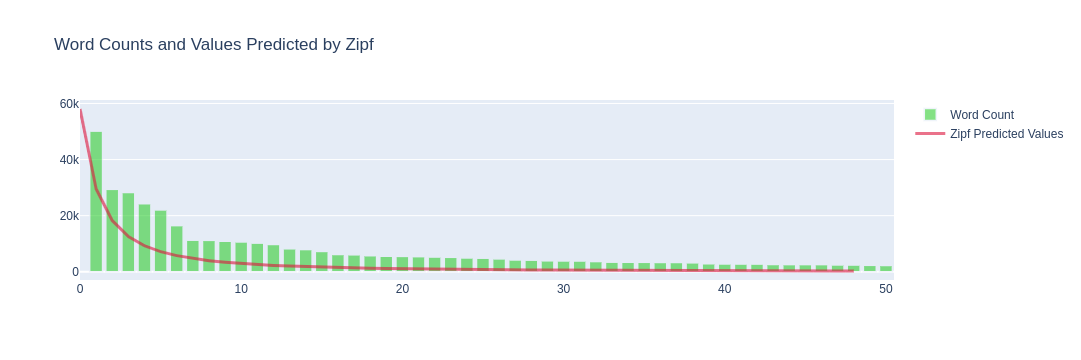

In [81]:
x =  termplot['rank']
y = termplot['total']

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=wordlist, name = "Word Count")])

fig.add_trace(go.Scatter(x =list(range(len(zipf_pmf))), y= zipf_pmf, line= plotly.graph_objs.scatter.Line(color='crimson', width=3), name='Zipf Predicted Values'))
# Customize aspect
fig.update_traces(marker_color='limegreen',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Word Counts and Values Predicted by Zipf')
fig.show()

#### Plot the original counts and the zipf-predicted counts

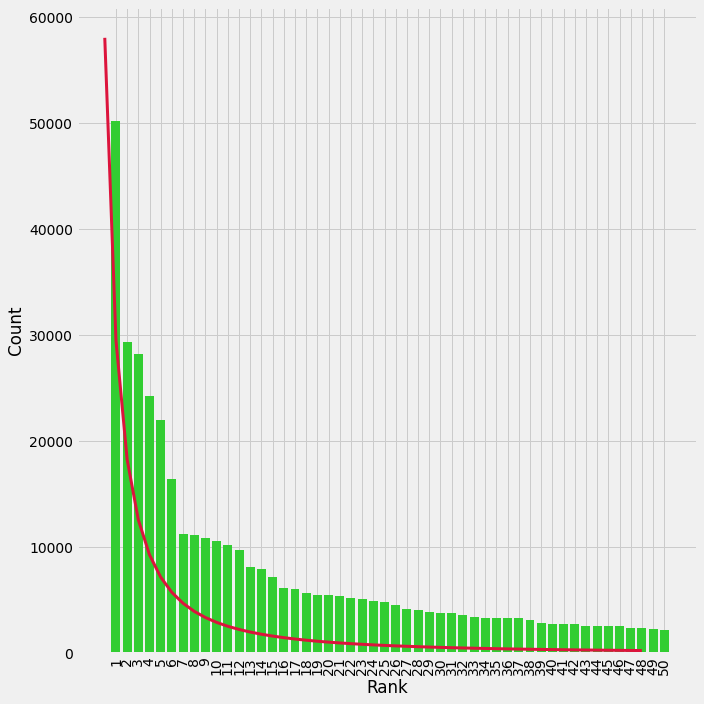

In [25]:
import matplotlib.pyplot as plt
from scipy.stats import zipf

totals = term_df['total'][:cutoff]
ranks = list(term_df['rank'])[:cutoff]
lst = list(zip(totals,ranks))
fig = plt.figure(figsize=(10,10))

plt.bar(ranks, totals, color='limegreen')
#alpha = 1.37065874
#summed_total = sum([p for p, c in lst])
#zipf_y = [zipf.pmf(p, alpha) * summed_total for p in range(1, len(lst) + 1)]
plt.plot(range(len(zipf_pmf)), zipf_pmf, color='crimson', lw=3)
plt.ylabel("Count")
plt.xlabel("Rank")
plt.xticks(ranks,ranks,rotation='vertical')
plt.tight_layout()
plt.show()

#### Create data structure for mapping the predictions to the original zipf histogram

### Graph out the observed and fitted pdf

Text(0.5, 0, "Log rank (binned frequencies).\nGaps signify there weren't observed words in the fitted frequency bin.")

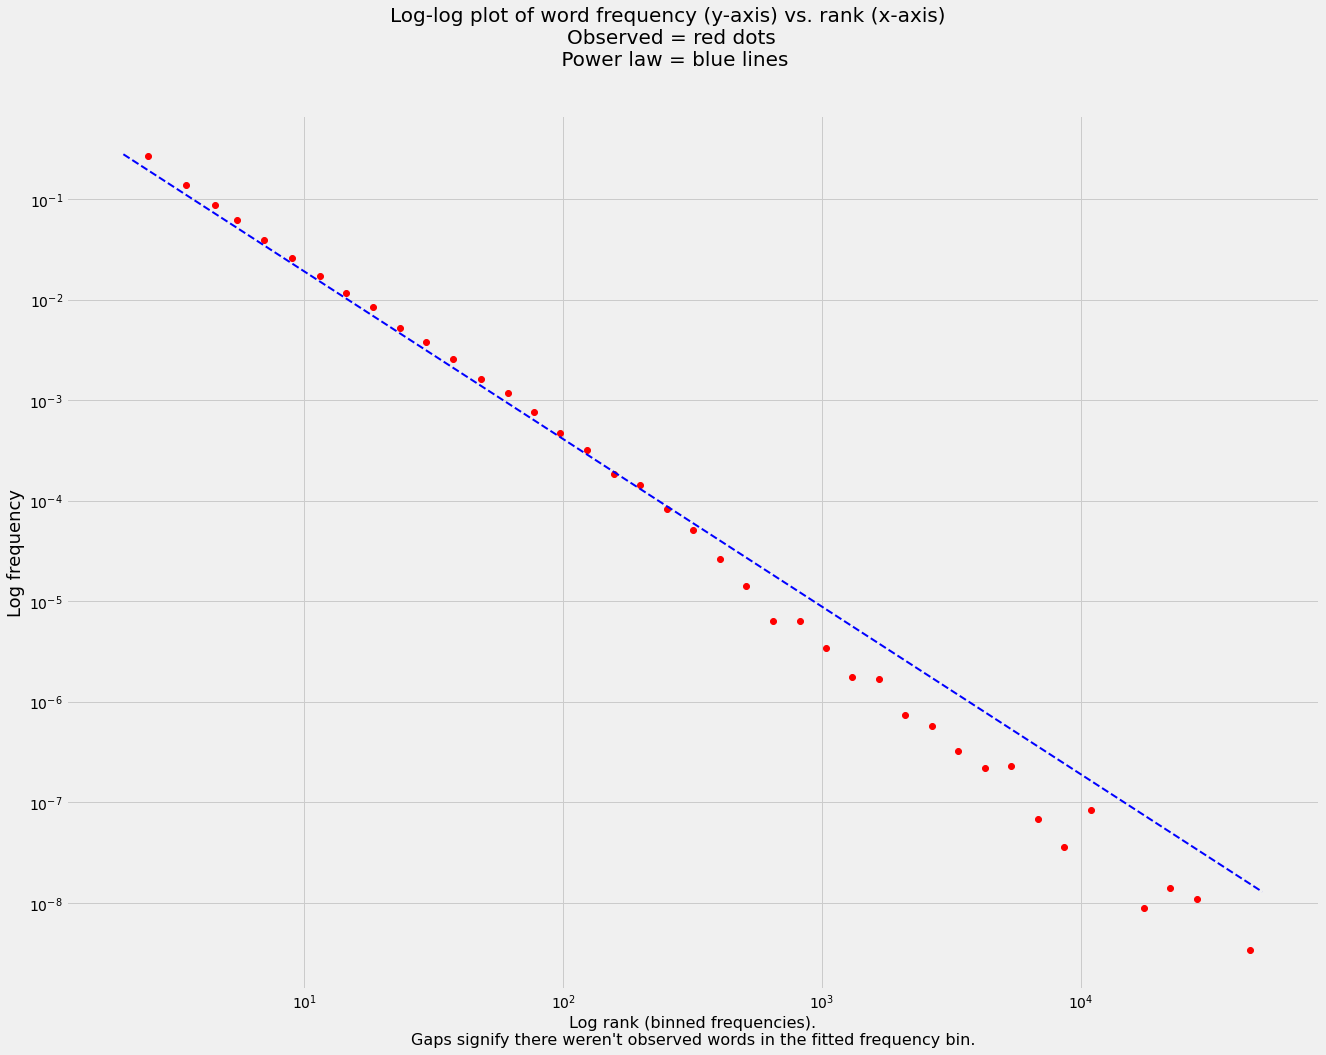

In [12]:
# Graph it out.
fig2 = plt.figure(figsize=(20,15))
# The pdf of the observed data. 
# The continuous line is superfluous and confusing I think (?) Hacky removing.
fit.plot_pdf(color='r', linewidth=0, linestyle=':', marker='o')
# The pdf of the best fit powerlaw
fit.power_law.plot_pdf(color='b', linestyle='--', linewidth=2)
fig2.suptitle('Log-log plot of word frequency (y-axis) vs. rank (x-axis) \nObserved = red dots\n Power law = blue lines', fontsize=20)
plt.ylabel('Log frequency', fontsize=18)
plt.xlabel('Log rank (binned frequencies).\nGaps signify there weren\'t observed words in the fitted frequency bin.', fontsize=16)

#### Check fit to other distributions.
#### This is comparing the log likelihood ratio of the power law distribution to alternative distributions: a truncated power law, an exponential distribution or a lognormal distribution.
#### NB: There's an issue here with handling correlations.
#### I'm not sure this is the best way to do this, esp bc it throws errors.


In [13]:
print("Checking log likelihood ratio to see if the data is better explained")
print("by other well-behaved distributions...")
# The first value returned from distribution_compare is the log likelihood ratio
better_distro = False
trunc = fit.distribution_compare('power_law', 'truncated_power_law')
if trunc[0] < 0:
    print("Seems a truncated power law is a better fit.")
    better_distro = True

lognormal = fit.distribution_compare('power_law', 'lognormal')
if lognormal[0] < 0:
    print("Seems a lognormal distribution is a better fit.")
    print("But don't panic -- that happens sometimes with language.")
    better_distro = True
    
exponential = fit.distribution_compare('power_law', 'exponential')
if exponential[0] < 0:
    print("Seems an exponential distribution is a better fit. Panic.")
    better_distro = True
    
if not better_distro:
    print("\nSeems your data is best fit by a power law. Celebrate!!")

Checking log likelihood ratio to see if the data is better explained
by other well-behaved distributions...


Assuming nested distributions



Seems your data is best fit by a power law. Celebrate!!


In [14]:
print("Our updated dataframe now looks like this:")
print(term_df.info())
print(term_df.head())
print('...')
print(term_df.tail())

Our updated dataframe now looks like this:
<class 'pandas.core.frame.DataFrame'>
Index: 49994 entries, the to ﬁne
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total        49994 non-null  int64  
 1   probability  49994 non-null  float64
 2   rank         49994 non-null  int64  
 3   zipf_pmf     49 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 1.9+ MB
None
     total  probability  rank      zipf_pmf
the  50142     0.047568     1  58023.711250
and  29384     0.027875     2  29507.872760
to   28256     0.026805     3  18263.223048
of   24251     0.023006     4  12588.108564
a    22043     0.020911     5   9287.735139
...
                   total   probability  rank  zipf_pmf
incompetently          1  9.486586e-07   579       NaN
incompetency           1  9.486586e-07   579       NaN
incompatibility        1  9.486586e-07   579       NaN
incompatibilities      1  9.486586e-07   579       NaN
ﬁne